# Module 2: Data Analysis
## Sprint 4: Capstone Project

### Data:
Ultimate 25k+ Matches Football Database from <a href='https://www.kaggle.com/datasets/prajitdatta/ultimate-25k-matches-football-database-european'>Kaggle</a>. <br>
Contains info about 25K matches, 10K players, 11 European countries.<br>
It has seasons from 2008 to 2016.

### The goal of the project:
<b> 1. Perform data analysis answering the questions: </b>
* Where leagues are located?
* Which leagues score the most/fewest goals?
* Who are the top scorers in each team and league?
* Is there such a thing as home advantage?

<b> 2. Implement models: </b>
* Predict which team will win the match.
* Predict how many goals each team will score in each match.

## Data extraction

Uploading needed libraries:

In [1]:
#!pip install geopandas
#!pip install matplotlib -U
import random
import sqlite3
import datetime
import warnings
import geopandas
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import metrics
import scipy.stats as stats
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

warnings.filterwarnings(action='ignore')

### Downloading the data

Dataset is loaded directly from Kaggle. <br>
Uploading json file with Kaggle username and key:

In [60]:
!pip install -q kaggle
from google.colab import files
files.upload()

{}

Downloading the zip dataset file and unzipping:

In [3]:
!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets list
!kaggle datasets download 'prajitdatta/ultimate-25k-matches-football-database-european'
!unzip ultimate-25k-matches-football-database-european.zip

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                         size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
ahsan81/hotel-reservations-classification-dataset               Hotel Reservations Dataset                   480KB  2023-01-04 12:50:31           3404        126  1.0              
thedevastator/global-fossil-co2-emissions-by-country-2002-2022  Emissions by Country, 2002-2022              621KB  2023-01-02 20:10:36           1720         58  1.0              
die9origephit/fifa-world-cup-2022-complete-dataset              Fifa World Cup 2022: Complete Dataset          7KB  2022-12-18 22:51:11           6552        202  1.0              
rakkesharv/spotify-top-10000-strea

### Looking at the database tables

In [2]:
conn = sqlite3.connect('database.sqlite')
df = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table'", conn)
print(df)

df_player = pd.read_sql_query("SELECT * FROM Player", conn)
df_player_attributes = pd.read_sql_query("SELECT * FROM Player_Attributes", conn)

df_match = pd.read_sql_query("SELECT * FROM Match", conn)
df_league = pd.read_sql_query("SELECT * FROM League", conn)
df_country = pd.read_sql_query("SELECT * FROM Country", conn)

df_team = pd.read_sql_query("SELECT * FROM Team", conn)
df_team_attributes = pd.read_sql_query("SELECT * FROM Team_Attributes", conn)

                name
0    sqlite_sequence
1  Player_Attributes
2             Player
3              Match
4             League
5            Country
6               Team
7    Team_Attributes


SQL database has 7 tables containing useful info. <br>
All of the tables and their sizes: <br>

In [3]:
print(df_player_attributes.shape)
df_player_attributes.head()

(183978, 42)


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling,gk_kicking,gk_positioning,gk_reflexes
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,54.0,48.0,65.0,69.0,69.0,6.0,11.0,10.0,8.0,8.0
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,54.0,48.0,65.0,66.0,69.0,6.0,11.0,10.0,8.0,8.0
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,53.0,47.0,62.0,63.0,66.0,5.0,10.0,9.0,7.0,7.0


In [4]:
print(df_player.shape)
df_player.head()

(11060, 7)


,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,155782,Aaron Cresswell,189615,1989-12-15 00:00:00,170.18,146
2,3,162549,Aaron Doran,186170,1991-05-13 00:00:00,170.18,163
3,4,30572,Aaron Galindo,140161,1982-05-08 00:00:00,182.88,198
4,5,23780,Aaron Hughes,17725,1979-11-08 00:00:00,182.88,154


In [5]:
print(df_league.shape)
df_league.head()

(11, 3)


,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A


In [6]:
print(df_match.shape)
df_match.head()

(25979, 115)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [7]:
print(df_country.shape)
df_country.head()

(11, 2)


,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy


In [8]:
print(df_team.shape)
df_team.head()

(299, 5)


,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In [9]:
print(df_team_attributes.shape)
df_team_attributes.head()

(1458, 25)


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,chanceCreationShooting,chanceCreationShootingClass,chanceCreationPositioningClass,defencePressure,defencePressureClass,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Normal,Organised,50,Medium,55,Press,45,Normal,Cover
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,64,Normal,Organised,47,Medium,44,Press,54,Normal,Cover
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Lots,Organised,60,Medium,70,Double,70,Wide,Cover
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,52,Normal,Organised,47,Medium,47,Press,52,Normal,Cover


### Connecting tables together

Players info:

In [10]:
sql = """SELECT * FROM Player_Attributes AS PA 
         LEFT JOIN Player AS P 
           ON PA.player_api_id = P.player_api_id
      """
df_player_attributes = pd.read_sql_query(sql, conn)
print(df_player_attributes.shape)
df_player_attributes.head()

(183978, 49)


,id,player_fifa_api_id,player_api_id,date,overall_rating,potential,preferred_foot,attacking_work_rate,defensive_work_rate,crossing,...,gk_kicking,gk_positioning,gk_reflexes,id,player_api_id,player_name,player_fifa_api_id,birthday,height,weight
0,1,218353,505942,2016-02-18 00:00:00,67.0,71.0,right,medium,medium,49.0,...,10.0,8.0,8.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
1,2,218353,505942,2015-11-19 00:00:00,67.0,71.0,right,medium,medium,49.0,...,10.0,8.0,8.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
2,3,218353,505942,2015-09-21 00:00:00,62.0,66.0,right,medium,medium,49.0,...,10.0,8.0,8.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
3,4,218353,505942,2015-03-20 00:00:00,61.0,65.0,right,medium,medium,48.0,...,9.0,7.0,7.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187
4,5,218353,505942,2007-02-22 00:00:00,61.0,65.0,right,medium,medium,48.0,...,9.0,7.0,7.0,1,505942,Aaron Appindangoye,218353,1992-02-29 00:00:00,182.88,187


Teams info:

In [11]:
sql = """SELECT * FROM Team_Attributes AS TA 
         LEFT JOIN Team AS T 
            ON TA.team_api_id = T.team_api_id
      """
df_team_attributes = pd.read_sql_query(sql, conn)
print(df_team_attributes.shape)
df_team_attributes.head()

(1458, 30)


,id,team_fifa_api_id,team_api_id,date,buildUpPlaySpeed,buildUpPlaySpeedClass,buildUpPlayDribbling,buildUpPlayDribblingClass,buildUpPlayPassing,buildUpPlayPassingClass,...,defenceAggression,defenceAggressionClass,defenceTeamWidth,defenceTeamWidthClass,defenceDefenderLineClass,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,434,9930,2010-02-22 00:00:00,60,Balanced,NaN,Little,50,Mixed,...,55,Press,45,Normal,Cover,49119,9930,434,FC Aarau,AAR
1,2,434,9930,2014-09-19 00:00:00,52,Balanced,48.0,Normal,56,Mixed,...,44,Press,54,Normal,Cover,49119,9930,434,FC Aarau,AAR
2,3,434,9930,2015-09-10 00:00:00,47,Balanced,41.0,Normal,54,Mixed,...,44,Press,54,Normal,Cover,49119,9930,434,FC Aarau,AAR
3,4,77,8485,2010-02-22 00:00:00,70,Fast,NaN,Little,70,Long,...,70,Double,70,Wide,Cover,39393,8485,77,Aberdeen,ABE
4,5,77,8485,2011-02-22 00:00:00,47,Balanced,NaN,Little,52,Mixed,...,47,Press,52,Normal,Cover,39393,8485,77,Aberdeen,ABE


Match info:

In [12]:
sql = """SELECT * FROM Match AS M 
         LEFT JOIN Country AS C 
            ON M.country_id = C.id
         LEFT JOIN League AS L 
            ON M.league_id = L.id
        LEFT JOIN Team AS T1
            ON M.home_team_api_id = T1.team_api_id
        LEFT JOIN Team AS T2 
            ON M.away_team_api_id = T2.team_api_id
      """
df_match = pd.read_sql_query(sql, conn)
print(df_match.shape)
df_match.head()

(25979, 130)


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1,9987,673.0,KRC Genk,GEN,2,9993,675.0,Beerschot AC,BAC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3,10000,15005.0,SV Zulte-Waregem,ZUL,4,9994,2007.0,Sporting Lokeren,LOK
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,5,9984,1750.0,KSV Cercle Brugge,CEB,6,8635,229.0,RSC Anderlecht,AND
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7,9991,674.0,KAA Gent,GEN,8,9998,1747.0,RAEC Mons,MON
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,9,7947,NaN,FCV Dender EH,DEN,10,9985,232.0,Standard de Liège,STL


League info:

In [13]:
sql = "SELECT * FROM League AS L LEFT JOIN Country AS C ON L.country_id = C.id"
df_league = pd.read_sql_query(sql, conn)
print(df_league.shape)
df_league = df_league.drop(columns=['id'])
df_league.columns = ['country_id', 'league', 'country']
df_league.head()

(11, 5)


,country_id,league,country
0,1,Belgium Jupiler League,Belgium
1,1729,England Premier League,England
2,4769,France Ligue 1,France
3,7809,Germany 1. Bundesliga,Germany
4,10257,Italy Serie A,Italy


## Data cleaning

### Checking for faulty or missing values

In [14]:
print(df_player_attributes.shape)
df_player_attributes.isnull().sum().sort_values(ascending=False).head(10) 

(183978, 49)


attacking_work_rate    3230
agility                2713
curve                  2713
volleys                2713
vision                 2713
balance                2713
sliding_tackle         2713
jumping                2713
gk_diving               836
standing_tackle         836
dtype: int64

df_player_attributes dataframe contains a lot of missing features.

In [15]:
print(df_team_attributes.shape)
df_team_attributes.isnull().sum().sort_values(ascending=False).head(5) 

(1458, 30)


buildUpPlayDribbling           969
id                               0
chanceCreationShootingClass      0
team_long_name                   0
team_fifa_api_id                 0
dtype: int64

df_team_attributes dataframe has only one feature with missing values. <br>
It is removed.

In [16]:
df_team_attributes = df_team_attributes.drop(columns=['buildUpPlayDribbling'])

In [17]:
print(df_match.shape)
df_match.isnull().sum().sort_values(ascending=False).head(20)

(25979, 130)


PSA           14811
PSD           14811
PSH           14811
BSA           11818
BSD           11818
BSH           11818
GBA           11817
GBD           11817
GBH           11817
goal          11762
shoton        11762
shotoff       11762
foulcommit    11762
card          11762
cross         11762
corner        11762
possession    11762
SJD            8882
SJA            8882
SJH            8882
dtype: int64

df_match dataframe has a lot of missing features. <br>
Some features with the most missing records are removed. <br>
Also records that contain missing values are also removed. From 25K records 20K records left. <br>

In [18]:
df_match = df_match.drop(['PSA', 'PSD', 'PSH', 'GBA', 'GBD', 'GBH', 
                          'BSA', 'BSD', 'BSH', 'SJH', 'SJD', 'SJA',
                          'card', 'possession', 'cross', 'foulcommit', 
                          'shotoff', 'shoton', 'goal', 'corner'], axis=1)
df_match = df_match[df_match.isnull().sum(axis=1)==0] 
df_match2 = df_match.copy()
df_match = df_match.drop(list(df_match.columns[df_match.columns.str.contains('player_X') | 
                                    df_match.columns.str.contains('player_Y')]), axis=1)

In [19]:
col = df_match.columns[df_match.columns.str.contains('player') & 
                       ~df_match.columns.str.contains('_X') & 
                       ~df_match.columns.str.contains('_Y')]

### Making new features

Creating player age, outcome and score features:

In [20]:
df_player_attributes['player_age'] = [relativedelta(datetime.datetime.strptime(x[:10], '%Y-%m-%d'), 
                                                    datetime.datetime.strptime(y[:10], '%Y-%m-%d')).years 
                                      for (x,y) in zip(df_player_attributes['date'], 
                                                       df_player_attributes['birthday'])]
outcome = []
for match in df_match.iterrows():
    if  match[1]['home_team_goal']>match[1]['away_team_goal']:
        outcome.append('Home Win')
    elif match[1]['home_team_goal']<match[1]['away_team_goal']:
        outcome.append('Away Win')
    elif match[1]['home_team_goal']==match[1]['away_team_goal']:
        outcome.append('Draw')
    else: 
        outcome.append('Error')
        
df_match['outcome'] = outcome 
df_match['score'] = [str(row['home_team_goal'])+':'+str(row['away_team_goal']) for index, row in df_match.iterrows()]

Removing few unnecessary columns:

In [21]:
df_player_attributes = df_player_attributes.drop(columns=['player_fifa_api_id', 'id', 'birthday'])
df_team_attributes = df_team_attributes.drop(columns=['team_fifa_api_id', 'id'])
df_match = df_match.drop(columns=['id', 'team_api_id', 'team_fifa_api_id'])   

### Creating one dataframe for forecasting

#### Joining players data

Steps:
1. Taking match data.
2. Joining with player data.
3. Selecting only records with the latest player data before match.
4. Aggregating the players statistics for each team and match by the mean and standart deviation.
5. Unstacking the dataframe to contain home and away teams data sideways.


Taking matches data and players data:

In [22]:
cols = df_match.columns[df_match.columns.str.contains('player') & 
                       ~df_match.columns.str.contains('_X') & 
                       ~df_match.columns.str.contains('_Y')]
cols = list(cols)
cols+=['match_api_id', 'date', 'season', 'team_long_name', 'name']
df = df_match[cols]
cols = df.columns.tolist()
cols[-1] = 'league_name'
cols[-2] = 'country'
cols[-3] = 'away_team_name'
cols[-4] = 'home_team_name'
df.columns = cols
df.set_index(['match_api_id', 'date', 'season', 'home_team_name', 'away_team_name', 'country', 'league_name'], inplace=True)
df = df.stack().to_frame().reset_index()
df.columns = ['match_api_id', 'date', 'season', 'home_team_name', 'away_team_name', 'country', 'league_name', 'player', 'player_api_id']
df['player_order'] = [s[12:] for s in df['player']]
df['location'] = [s[:4] for s in df['player']]
df['player_api_id'] = df['player_api_id'].astype(int)
df.head()

,match_api_id,date,season,home_team_name,away_team_name,country,league_name,player,player_api_id,player_order,location
0,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_1,38327,1,home
1,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_2,67950,2,home
2,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_3,67958,3,home
3,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_4,67959,4,home
4,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_5,37112,5,home


Joining it together:

In [23]:
df = df.merge(df_player_attributes.iloc[:,np.r_[0:3,-4,7:37]], on='player_api_id', how='left')
df.head()

,match_api_id,date_x,season,home_team_name,away_team_name,country,league_name,player,player_api_id,player_order,...,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling
0,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_1,38327,1,...,29.0,19.0,12.0,43.0,13.0,13.0,13.0,13.0,69.0,66.0
1,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_1,38327,1,...,28.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,68.0,65.0
2,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_1,38327,1,...,28.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,68.0,65.0
3,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_1,38327,1,...,28.0,25.0,25.0,25.0,25.0,25.0,25.0,25.0,68.0,63.0
4,493017,2009-02-27 00:00:00,2008/2009,KV Mechelen,KRC Genk,Belgium,Belgium Jupiler League,home_player_1,38327,1,...,57.0,23.0,11.0,31.0,12.0,12.0,12.0,12.0,67.0,61.0


Selecting only players records that were recorded before match, selecting the closest record:

In [24]:
df = df[df['date_x']>df['date_y']]
p = df[['date_x','date_y']].apply(pd.to_datetime) 
df['diff'] = (p['date_x'] - p['date_y']).dt.days

df['rank'] = df.groupby(['match_api_id', 'player_api_id'])['diff'].rank(method="first", ascending=True)
df = df[df['rank']==1]
df3 = df.copy()
df.drop(['date_y', 'diff', 'rank', 'date_x', 'player_api_id', 'player_order', 
         'home_team_name',	'away_team_name', 'country', 'league_name', 'season'], 
        inplace=True, axis=1)
df.head()

,match_api_id,player,location,overall_rating,player_name,crossing,finishing,heading_accuracy,short_passing,volleys,...,aggression,interceptions,positioning,vision,penalties,marking,standing_tackle,sliding_tackle,gk_diving,gk_handling
11,493017,home_player_1,home,58.0,Wouter Biebauw,25.0,25.0,25.0,25.0,10.0,...,57.0,40.0,33.0,50.0,48.0,25.0,25.0,35.0,63.0,51.0
25,493017,home_player_2,home,57.0,Kenny van Hoevelen,37.0,32.0,62.0,39.0,34.0,...,61.0,61.0,37.0,59.0,52.0,66.0,57.0,65.0,13.0,20.0
58,493017,home_player_3,home,67.0,Nana Asare,62.0,52.0,49.0,67.0,51.0,...,49.0,57.0,52.0,70.0,55.0,60.0,65.0,65.0,9.0,20.0
74,493017,home_player_4,home,53.0,Maxime Biset,37.0,43.0,46.0,47.0,31.0,...,55.0,48.0,56.0,59.0,57.0,40.0,42.0,63.0,5.0,22.0
100,493017,home_player_5,home,60.0,Julien Gorius,49.0,48.0,52.0,74.0,67.0,...,42.0,65.0,63.0,69.0,52.0,47.0,42.0,57.0,8.0,20.0


Aggregating the players statistics by match and team:

In [25]:
df = df.groupby(['match_api_id', 'location'])\
       .agg({col: ['mean', 'std'] for i, col in enumerate(df.columns[5:])})\
       .round(2).reset_index()
df.columns = list(map('_'.join, df.columns.values))
df.head()

,match_api_id_,location_,crossing_mean,crossing_std,finishing_mean,finishing_std,heading_accuracy_mean,heading_accuracy_std,short_passing_mean,short_passing_std,...,marking_mean,marking_std,standing_tackle_mean,standing_tackle_std,sliding_tackle_mean,sliding_tackle_std,gk_diving_mean,gk_diving_std,gk_handling_mean,gk_handling_std
0,483130,away,56.27,15.66,53.45,18.81,54.18,16.60,66.36,14.29,...,55.45,20.33,52.91,19.23,52.11,21.23,14.18,19.77,25.91,17.17
1,483130,home,53.09,14.92,47.64,17.51,67.64,19.47,65.64,16.54,...,60.73,24.83,61.18,25.10,61.70,24.15,15.64,22.17,27.55,18.45
2,483131,away,50.82,14.68,50.18,18.42,62.09,19.59,65.91,16.04,...,51.18,22.67,52.64,22.56,47.22,24.56,14.45,18.98,26.09,14.30
3,483131,home,44.09,14.56,43.64,21.71,57.36,18.74,57.91,16.14,...,51.00,20.63,49.73,19.20,55.22,16.11,13.09,21.64,22.73,15.40
4,483133,away,55.73,19.70,45.45,17.57,62.64,16.33,62.27,14.79,...,53.27,24.36,54.91,22.21,52.91,26.35,13.55,21.91,26.64,16.13


Unstacking the dataframe to contain home and away teams data sideways instead of one after each other:

In [26]:
cols1 = df.columns.tolist()[1:]
df = df.set_index(['location_']).T.reset_index(drop=True) \
    .T.groupby(level=0).apply(lambda df: df.reset_index(drop=True)) \
    .stack().unstack(1).T  
cols2 = df.columns.levels[0].tolist()
cols = [x+'_'+y for x in cols2 for y in cols1]
df.columns = cols
df.drop('home_location_', inplace=True, axis=1)
df.rename(columns={'away_location_':'match_api_id'}, inplace=True)
df.head()

,match_api_id,away_crossing_mean,away_crossing_std,away_finishing_mean,away_finishing_std,away_heading_accuracy_mean,away_heading_accuracy_std,away_short_passing_mean,away_short_passing_std,away_volleys_mean,...,home_marking_mean,home_marking_std,home_standing_tackle_mean,home_standing_tackle_std,home_sliding_tackle_mean,home_sliding_tackle_std,home_gk_diving_mean,home_gk_diving_std,home_gk_handling_mean,home_gk_handling_std
0,483130.0,56.27,15.66,53.45,18.81,54.18,16.60,66.36,14.29,44.33,...,60.73,24.83,61.18,25.10,61.70,24.15,15.64,22.17,27.55,18.45
1,483131.0,50.82,14.68,50.18,18.42,62.09,19.59,65.91,16.04,47.00,...,51.00,20.63,49.73,19.20,55.22,16.11,13.09,21.64,22.73,15.40
2,483133.0,55.73,19.70,45.45,17.57,62.64,16.33,62.27,14.79,46.00,...,56.09,25.34,58.36,26.92,54.73,27.95,15.27,23.63,25.09,16.75
3,483134.0,59.09,22.65,46.91,22.03,59.18,16.96,65.36,19.45,50.36,...,51.36,22.56,51.09,22.21,52.82,23.23,14.64,18.22,22.36,14.66
4,483135.0,58.36,19.10,57.73,18.31,60.64,19.36,69.91,19.90,48.09,...,50.18,22.41,52.27,21.71,41.00,28.52,14.18,19.84,25.18,16.02


#### Joining teams data

Same steps like with players data above.

In [27]:
ls = []
for i, team_api in enumerate(['home_team_api_id',	'away_team_api_id']):
  df1 = df_match[['match_api_id', 'date', 'home_team_api_id',	'away_team_api_id']]
  df2 = df_team_attributes[df_team_attributes._get_numeric_data().columns].iloc[:, 1:10]
  cols = df_team_attributes._get_numeric_data().columns.tolist()
  cols.insert(1, 'date')
  df2 = df_team_attributes[cols].iloc[:, 1:11]
  dff = df1.merge(df2 , left_on=team_api, right_on='team_api_id', how='left')
  dff = dff[dff['date_x']>dff['date_y']]
  p = dff[['date_x','date_y']].apply(pd.to_datetime) 
  dff['diff'] = (p['date_x'] - p['date_y']).dt.days
  dff['rank'] = dff.groupby(['match_api_id', team_api])['diff'].rank(method="first", ascending=True)
  dff = dff[dff['rank']==1]
  dff.drop(['date_y', 'diff', 'rank', 'date_x'], inplace=True, axis=1)
  dff.columns = [team_api[:4]+'_'+col for col in dff.columns.values]
  ls.append(dff)

dff = df_match[['match_api_id']].merge(ls[0], left_on='match_api_id', right_on='home_match_api_id', how='left')
dff = dff.merge(ls[1], left_on='match_api_id', right_on='away_match_api_id', how='left')
dff.drop(['home_match_api_id', 'home_home_team_api_id', 'home_away_team_api_id', 
          'home_team_api_id', 'away_match_api_id',	'away_home_team_api_id',	
          'away_away_team_api_id',	'away_team_api_id'], 
         inplace=True, axis=1)
dff.head()

,match_api_id,home_buildUpPlaySpeed,home_buildUpPlayPassing,home_chanceCreationPassing,home_chanceCreationCrossing,home_chanceCreationShooting,home_defencePressure,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,493017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,493025,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,493027,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,493034,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,493040,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Final joins

Joining match data together with dataframes of players and teams info, that were created above. <br>
This final dataframe will be used for forecasting.

In [28]:
df2 = df_match[['stage', 'match_api_id', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD',	\
                'BWA',	'IWH',	'IWD',	'IWA',	'LBH',	'LBD',	'LBA',	'WHH',	\
                'WHD',	'WHA',	'VCH',	'VCD',	'VCA', 'score', 'outcome']]
df = df.merge(df2, on='match_api_id', how='left')
df = df.merge(dff, on='match_api_id', how='left')
df.head()

,match_api_id,away_crossing_mean,away_crossing_std,away_finishing_mean,away_finishing_std,away_heading_accuracy_mean,away_heading_accuracy_std,away_short_passing_mean,away_short_passing_std,away_volleys_mean,...,home_defenceAggression,home_defenceTeamWidth,away_buildUpPlaySpeed,away_buildUpPlayPassing,away_chanceCreationPassing,away_chanceCreationCrossing,away_chanceCreationShooting,away_defencePressure,away_defenceAggression,away_defenceTeamWidth
0,483130.0,56.27,15.66,53.45,18.81,54.18,16.60,66.36,14.29,44.33,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,483131.0,50.82,14.68,50.18,18.42,62.09,19.59,65.91,16.04,47.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,483133.0,55.73,19.70,45.45,17.57,62.64,16.33,62.27,14.79,46.00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,483134.0,59.09,22.65,46.91,22.03,59.18,16.96,65.36,19.45,50.36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,483135.0,58.36,19.10,57.73,18.31,60.64,19.36,69.91,19.90,48.09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Analysis

### General

Info about the dataset:

In [29]:
print('Data from:', min(df_player_attributes['date']))
print('Data until: ', max(df_player_attributes['date']))
print('Seasons:', len(df_match['season'].unique()))
print('Countries and leagues:', len(df_match['league_id'].unique()))
print('Unique teams: ', len(df_team_attributes['team_long_name'].unique()))
print('Unique players: ', len(df_player_attributes['player_name'].unique()))
print('Unique matches: ', len(df_match['match_api_id'].unique()))

Data from: 2007-02-22 00:00:00
Data until:  2016-07-07 00:00:00
Seasons: 8
Countries and leagues: 9
Unique teams:  285
Unique players:  10848
Unique matches:  19481


In [30]:
df_player_attributes['player_name'].value_counts()

Danilo                108
Alex                  104
Douglas                93
Felipe                 89
Ricardo                84
                     ... 
Thomas Kotte            2
Levi Opdam              2
Christopher Nkunku      2
Giancarlo               2
Ryan Thomson            2
Name: player_name, Length: 10848, dtype: int64

It has info about players and teams collected on multiple dates. <br>

### Leagues

Leagues and countries in the dataset:

In [31]:
df_league.sort_values('country').iloc[:, 1:]

,league,country
0,Belgium Jupiler League,Belgium
1,England Premier League,England
2,France Ligue 1,France
3,Germany 1. Bundesliga,Germany
4,Italy Serie A,Italy
5,Netherlands Eredivisie,Netherlands
6,Poland Ekstraklasa,Poland
7,Portugal Liga ZON Sagres,Portugal
8,Scotland Premier League,Scotland
9,Spain LIGA BBVA,Spain


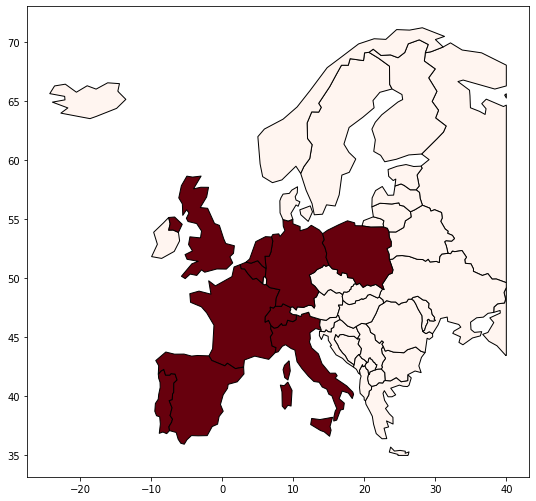

In [32]:
polygon = Polygon([(-25,35), (40,35), (40,75),(-25,75)])
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
europe=world[world.continent=='Europe']
europe=geopandas.clip(europe, polygon)
countries = df_league['country'].append(pd.Series(['United Kingdom']))
europe['color'] = europe.name.isin(countries).astype(int)
europe.plot(edgecolor='black', column='color', cmap='Reds', figsize=(9, 9));

Selecting the latest season - 2015/2016 <br>
Some statistics per league:

In [33]:
pp = df_match[df_match['season']=='2015/2016'][['name', 'home_team_goal', 'away_team_goal', 'outcome']]
pp.columns = ['country', 'league', 'home_team_goal', 'away_team_goal', 'outcome']
pp['sum_goals'] = pp['home_team_goal'] + pp['away_team_goal']
pp['home_win'] = (pp['outcome']=='Home Win').astype(int)
pp['away_win'] = (pp['outcome']=='Away Win').astype(int)
p = pp.groupby('league').agg({'home_team_goal': ['count', 'sum', 'mean'],
                         'away_team_goal': ['sum', 'mean'],
                         'sum_goals': ['sum', 'mean'],
                         'home_win': 'sum',
                         'away_win': 'sum'}).round(2).reset_index()
p.columns = ['league', 'matches', 'home_sum', 'home_avg', 'away_sum', 
             'away_avg', 'all_sum', 'all_avg', 'home_win', 'away_win']
p = p.sort_values('all_sum', ascending=False)
p

,league,matches,home_sum,home_avg,away_sum,away_avg,all_sum,all_avg,home_win,away_win
1,England Premier League,376,560,1.49,455,1.21,1015,2.70,155,115
8,Spain LIGA BBVA,351,555,1.58,399,1.14,954,2.72,168,98
2,France Ligue 1,348,507,1.46,373,1.07,880,2.53,148,99
3,Germany 1. Bundesliga,306,479,1.57,387,1.26,866,2.83,135,100
4,Italy Serie A,335,469,1.40,361,1.08,830,2.48,150,101
5,Netherlands Eredivisie,271,440,1.62,370,1.37,810,2.99,123,85
0,Belgium Jupiler League,224,371,1.66,269,1.20,640,2.86,108,63
6,Portugal Liga ZON Sagres,205,318,1.55,266,1.30,584,2.85,83,67
7,Scotland Premier League,197,306,1.55,258,1.31,564,2.86,89,71


Leagues where teams are scoring the most per game on average:

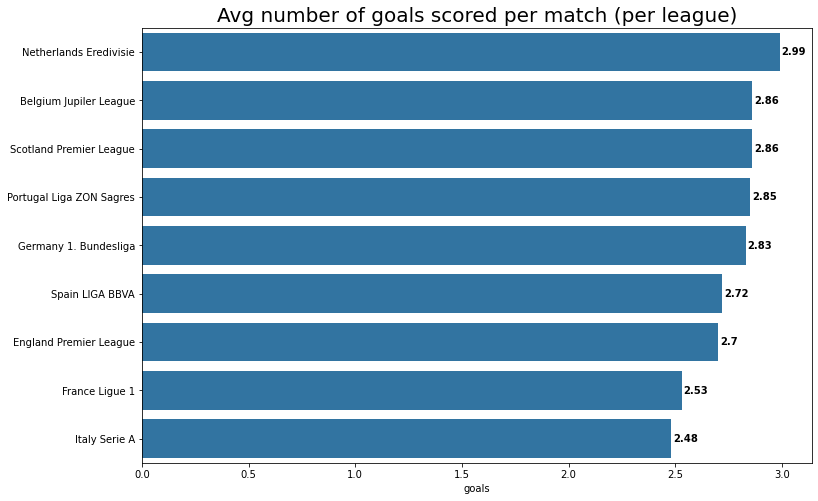

In [34]:
fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x = 'all_avg', 
                 y = 'league', 
                 data = p.sort_values(['all_avg'], 
                 ascending=False), 
                 color=sns.color_palette()[0])
plt.title(label = 'Avg number of goals scored per match (per league)', size=20)
plt.xlabel('goals')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')

<b>Research question:</b> Considering the given dataset, did 'Netherlands Eredivisie' score significantly more goals than the average? <br>
<b>Population:</b> European footbal matches of 9 leagues in 2005/2006 season. <br>
<b>Null hypothesis:</b> $\mu_{NE} = \mu $ <br>
<b>Alternative hypothesis:</b> $\mu_{NE} > \mu $ <br>
<b>Significance level:</b> is $\alpha$ = 0.05

In [35]:
from statsmodels.stats.weightstats import ztest
selected = pp[pp['league']=='Netherlands Eredivisie']['sum_goals']
mean = pp['sum_goals'].mean()
print(f"Average number of goals per match: {np.round(mean,2)}")
t_value, p_value = ztest(selected, value=mean, alternative='larger')
print(f"t-value:{np.round(t_value,4)}, p-value: {np.round(p_value,4)}")

Average number of goals per match: 2.73
t-value:2.5542, p-value: 0.0053


As p-value<0.05, we have enough evidence to reject Null hypothesis. The number of goals scored by 'Netherlands Eredivisie' per match is significantly higher than the average. <br><br>
Is there home advantage?

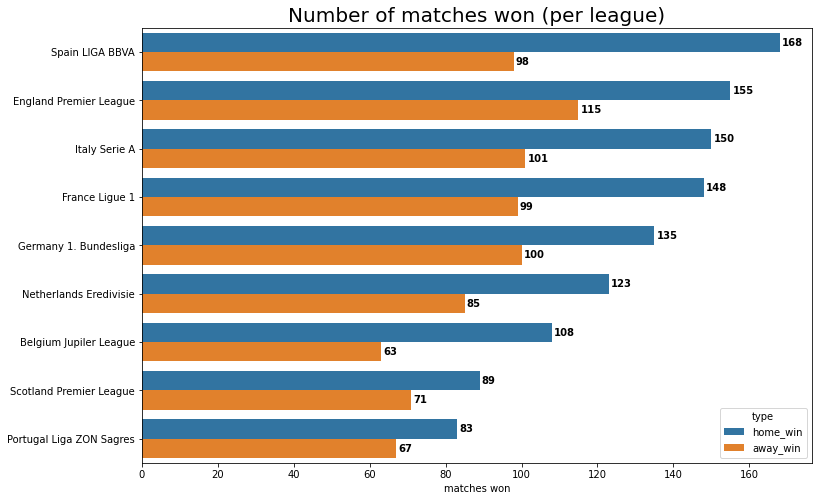

In [36]:
t = pd.melt(p, id_vars='league', 
            value_vars=['home_win', 'away_win']).sort_values(['variable', 'value'], ascending=False)
t.columns = ['league', 'type', 'wins']
fig = plt.figure(figsize=(12, 8))
ax = sns.barplot(x = "wins", y = "league", hue = "type", data = t)
plt.title(label = 'Number of matches won (per league)', size=20)
plt.xlabel('matches won')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')

<b>Research question:</b> Considering the given dataset, is there a home advantage?<br>
<b>Population:</b> European footbal matches of 9 leagues in 2005/2006 season.<br>
<b>Null hypothesis:</b> $P_{home} = P_{away} $ <br>
<b>Alternative hypothesis:</b> $P_{home} \neq P_{away} $ <br>
<b>Significance level:</b> is $\alpha$ = 0.05

In [37]:
from statsmodels.stats.proportion import proportions_ztest
t = pd.melt(p, id_vars='league', value_vars=['home_win', 'away_win'])\
      .groupby('variable')\
      .sum()\
      .sort_values('value')\
      .reset_index()
t.columns = ['type', 'wins']
n = t['wins'].sum()
proportion = np.round(t['wins'].iloc[1]/t['wins'].sum(),3) #Observed proportion
hypothesised_proportion = 0.50*n #Successes if Null Hypothesis is True
t_value, p_value = proportions_ztest(count=hypothesised_proportion, 
                                     nobs=n, 
                                     value=proportion, 
                                     alternative='two-sided')
print(f"t-value:{np.round(t_value,4)}, p-value: {np.round(p_value,4)}")

t-value:-8.1419, p-value: 0.0


There is a definitely home advantage.
As p-value<0.05, we have enough evidence to reject Null hypothesis meaning that there is a significant home advantage.

### Teams

Best teams in the leagues by number of matches won:

In [38]:
pp = df_match[(df_match['season']=='2015/2016')][['match_api_id', 'home_team_goal',	
                                                  'away_team_goal', 'team_long_name', 
                                                  'outcome', 'name']]
pp['outcome_home'] = [1 if x=='Home Win' else 0 for x in pp['outcome']]
pp['outcome_away'] = [1 if x=='Away Win' else 0 for x in pp['outcome']]
unique = pp.iloc[:,-3].sort_values(ascending=False).unique()
palette = dict(zip(unique, sns.color_palette(n_colors=len(unique))))
p1 = pp.iloc[:, [6, 7, 3, 1, 8]]
p2 = pp.iloc[:, [6, 7, 4, 2, 9]]
p1.columns = ['country', 'league', 'team_name', 'team_goal', 'wins']
p2.columns = ['country', 'league', 'team_name', 'team_goal', 'wins']
pp = pd.concat([p1, p2], axis=0)
pp = pp.groupby(['country', 'league', 'team_name'])['team_goal', 'wins']\
          .agg({'team_goal': ['sum'], 
                'wins': ['sum', 'count']})\
          .reset_index()
pp.columns = ['country', 'league', 'team_name', 'team_goal', 'wins_sum', 'wins_count']
pp['wins_perc'] = np.round(pp['wins_sum']/pp['wins_count'],2)
dff = pp.sort_values(['wins_sum', 'league'], ascending=False).reset_index(drop=True)[:15]
dff.head()

,country,league,team_name,team_goal,wins_sum,wins_count,wins_perc
0,Spain,Spain LIGA BBVA,Atlético Madrid,63,28,38,0.74
1,Spain,Spain LIGA BBVA,Real Madrid CF,110,28,38,0.74
2,Italy,Italy Serie A,Juventus,73,28,37,0.76
3,Germany,Germany 1. Bundesliga,FC Bayern Munich,80,28,34,0.82
4,France,France Ligue 1,Paris Saint-Germain,96,28,36,0.78


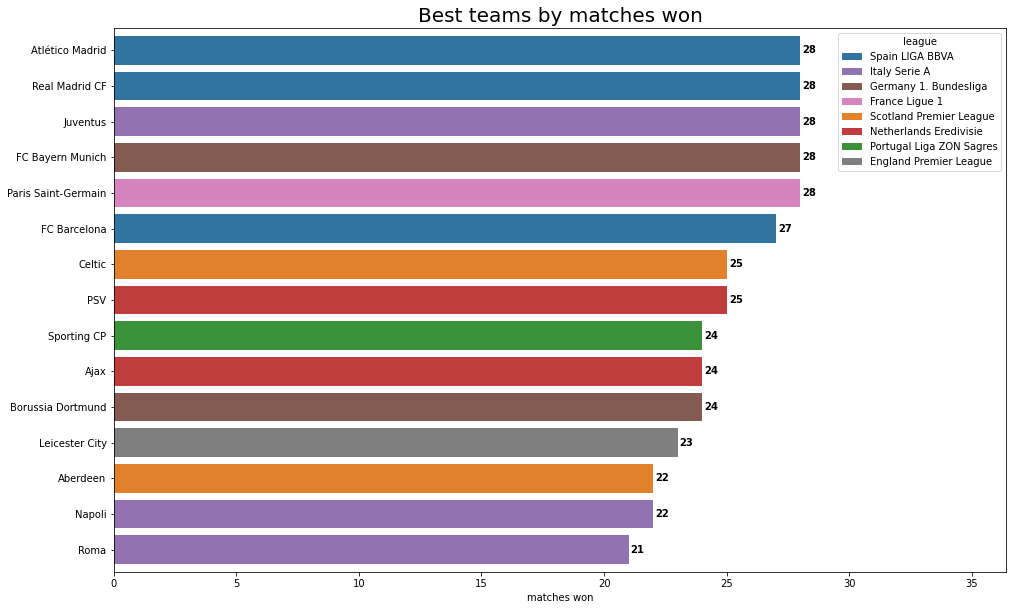

In [39]:
fig = plt.figure(figsize=(16, 10))
ax = sns.barplot(x='wins_sum', 
                 y='team_name', 
                 hue='league', 
                 dodge=False, 
                 data=dff, 
                 palette=palette)
plt.title(label = 'Best teams by matches won', size=20)
plt.xlabel('matches won')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')
ax.margins(x=0.3, y=0.015)

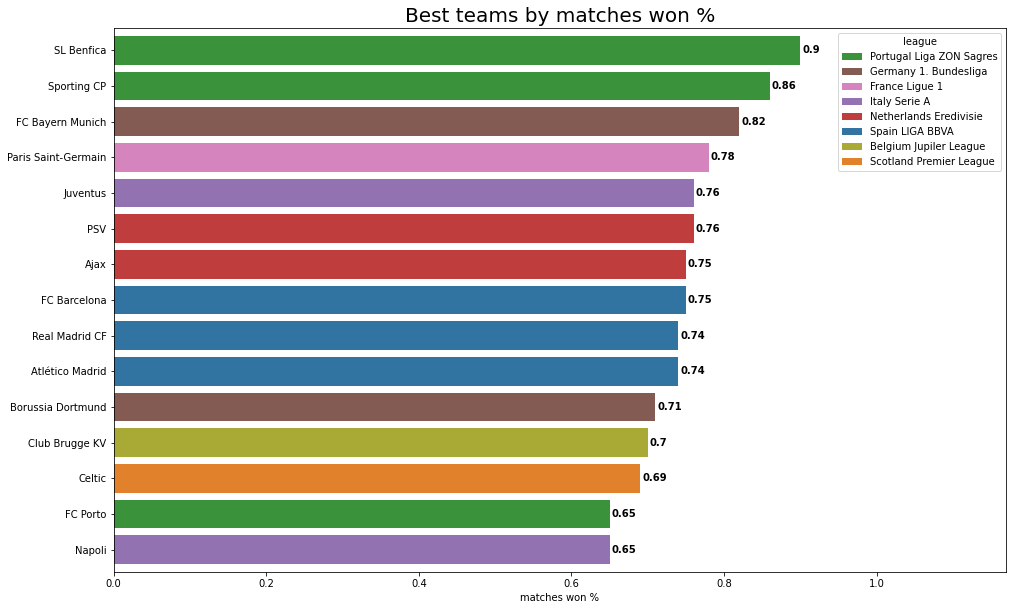

In [40]:
dff = pp.sort_values('wins_perc', ascending=False).reset_index(drop=True)[:15]
fig = plt.figure(figsize=(16, 10))
ax = sns.barplot(x='wins_perc', 
                 y='team_name', 
                 hue='league', 
                 dodge=False, 
                 data=dff, 
                 palette=palette)
plt.title(label = 'Best teams by matches won %', size=20)
plt.xlabel('matches won %')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')
ax.margins(x=0.3, y=0.015)

Best teams in the leagues by total goals scored:

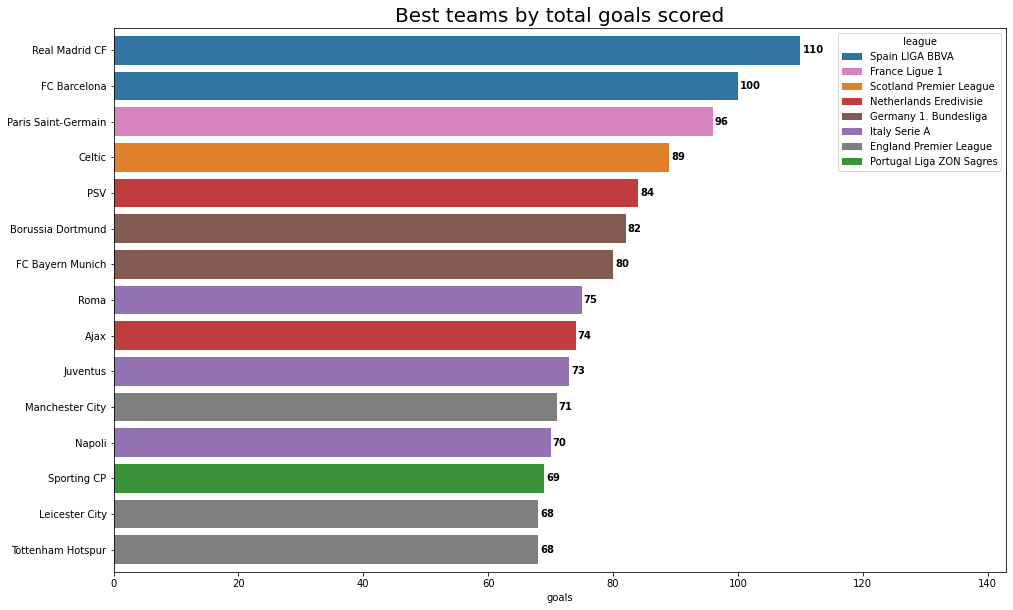

In [41]:
dff = pp.sort_values('team_goal', ascending=False).reset_index(drop=True)[:15]
fig = plt.figure(figsize=(16, 10))
ax = sns.barplot(x='team_goal', 
                 y='team_name', 
                 hue='league', 
                 dodge=False, 
                 data=dff, 
                 palette=palette)
plt.title(label = 'Best teams by total goals scored', size=20)
plt.xlabel('goals')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')
ax.margins(x=0.3, y=0.015)

### Players

Which player attributes are making him best rated player?

In [42]:
corr = df_player_attributes.corr()
corr = corr[corr['overall_rating']>0.4]['overall_rating']\
            .sort_values(ascending=False)[1:].round(2).reset_index()
corr

,index,overall_rating
0,reactions,0.77
1,potential,0.77
2,short_passing,0.46
3,ball_control,0.44
4,long_passing,0.44
5,vision,0.43
6,shot_power,0.43


Attribures correlated with overall player rating: reactions, potential, short_passing, ball_control, long_passing, vision, shot_power.

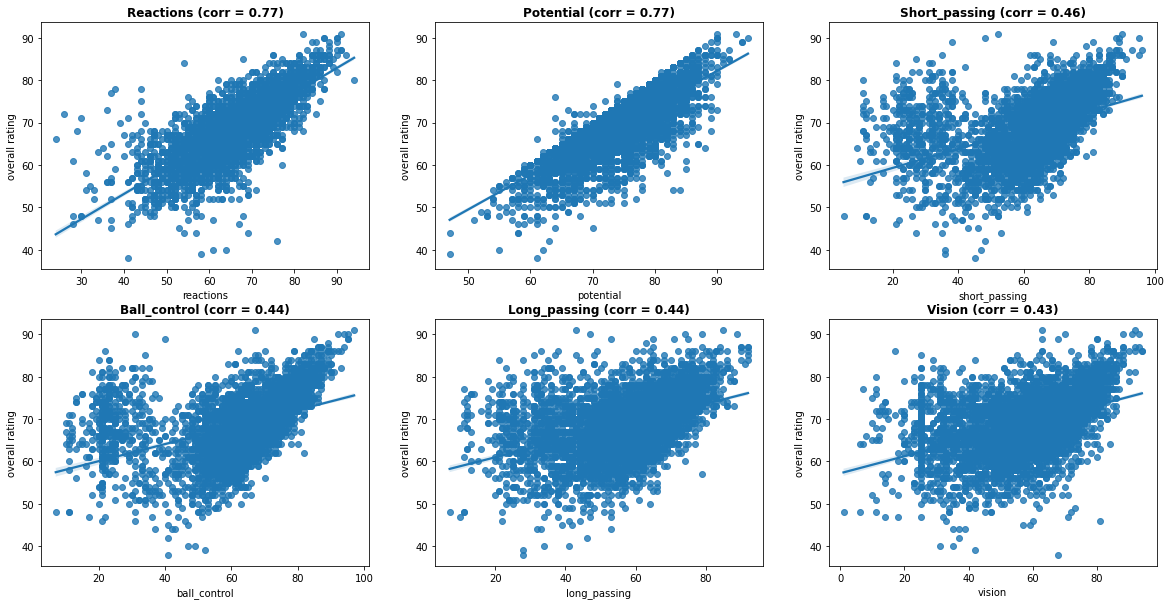

In [43]:
ls = random.sample(range(0, 183977), 5000)
p = df_player_attributes.iloc[ls]
features = corr['index'].tolist()
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(20, 10))

for i, ax in enumerate(fig.axes):
    sns.regplot(y='overall_rating', x=features[i], data=p, ax=ax)
    ax.set_title(features[i].capitalize()+' (corr = '+str(np.round(corr['overall_rating'][i],2))+')', 
                 fontweight='bold')
    ax.set_ylabel('overall rating') 
    ax.set_xlabel(features[i])

Best player in each league (by overall rating):

In [44]:
df3 = df3[(df3['season']=='2015/2016')]
df3['team_name'] = [row['home_team_name'] if row['location']=='home' else row['away_team_name'] for index, row in df3.iterrows()]
dff = df3.groupby(['country',	'league_name', 'team_name', 
                   'player_name', 'season'])['overall_rating'].max().reset_index()
dff.sort_values('overall_rating', ascending=False).groupby(['league_name'])['league_name','team_name', 'player_name', 'overall_rating'].head(1)

,league_name,team_name,player_name,overall_rating
3566,Spain LIGA BBVA,FC Barcelona,Lionel Messi,94.0
1585,Germany 1. Bundesliga,FC Bayern Munich,Arjen Robben,90.0
483,England Premier League,Chelsea,Eden Hazard,89.0
1290,France Ligue 1,Paris Saint-Germain,Zlatan Ibrahimovic,89.0
2131,Italy Serie A,Juventus,Giorgio Chiellini,87.0
3004,Portugal Liga ZON Sagres,FC Porto,Iker Casillas,84.0
2435,Netherlands Eredivisie,Ajax,Jasper Cillessen,82.0
381,Belgium Jupiler League,Standard de Liège,Victor Valdes,81.0
3233,Scotland Premier League,Celtic,Craig Gordon,76.0


Best players and their leagues (by overall rating):

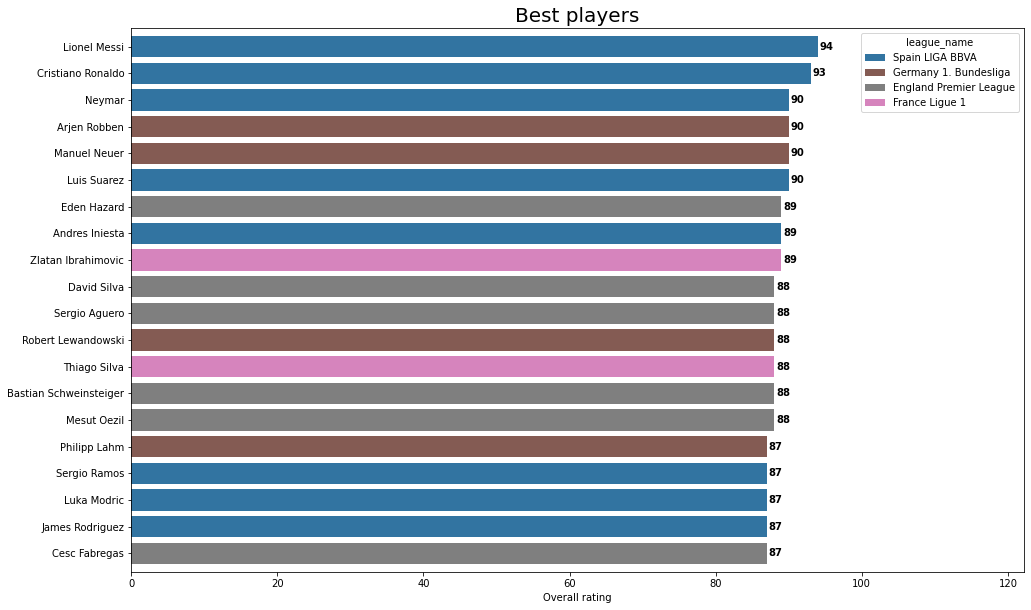

In [45]:
fig = plt.figure(figsize=(16, 10))
dff = dff.sort_values('overall_rating', ascending=False)[:20]
ax = sns.barplot(x='overall_rating', 
                 y='player_name', 
                 hue='league_name', 
                 dodge=False, 
                 data=dff, 
                 palette=palette)
plt.title(label = 'Best players', size=20)
plt.xlabel('Overall rating')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')
ax.margins(x=0.3, y=0.015)

Recording the dataframe to a csv file for making Data Studio dashboards.

In [46]:
df3.to_csv('matches.csv', index=False)

## Forecasting

### Predicting the winner

Preparing and dividing the data:

In [47]:
X = df[df.columns[~df.columns.isin(['outcome', 'score'])]]

X.fillna(X.mean(), inplace=True)
cols = X.columns
sc = StandardScaler()
X = sc.fit_transform(X)
y = df['outcome']
d = {'Away Win':1, 'Home Win':2, 'Draw':3}
y = [d[k] for k in y]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

The most important features:

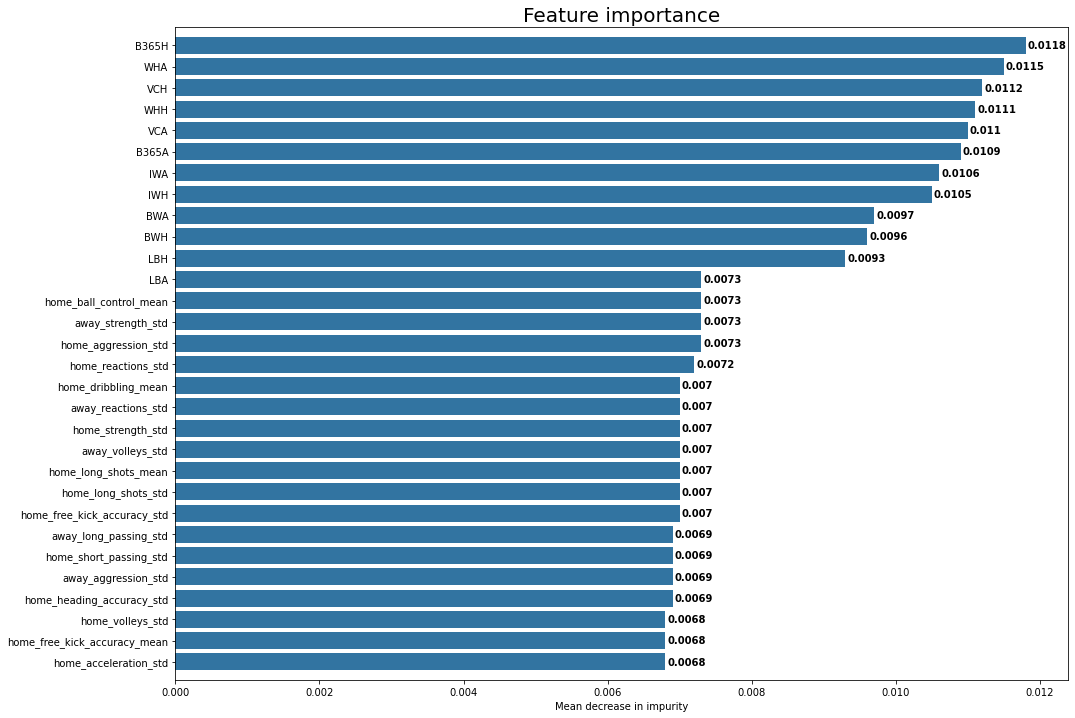

In [48]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
importances = model.feature_importances_
importances = (pd.DataFrame(importances, cols, columns = ['importance'])).round(4).sort_values(by='importance', ascending=False).reset_index()

fig = plt.figure(figsize=(16, 12))
ax = sns.barplot(x='importance', y='index', data=importances[:30], color=sns.color_palette()[0])
plt.title(label = 'Feature importance', size=20)
plt.xlabel('Mean decrease in impurity')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')
ax.margins(x=0.05, y=0.015)

Creating the model:

In [49]:
model = LogisticRegression(solver='newton-cg', 
                           random_state=0, 
                           multi_class='multinomial').fit(X_train, y_train)

print("Intercept:\n",model.intercept_)
#print("Coefficients:\n",model.coef_)

y_pred = model.predict(X_test)
print("Few predictions:\n", y_pred[:10])

Intercept:
 [-0.21312093  0.37488756 -0.16176664]
Few predictions:
 [2 2 2 2 2 2 2 1 1 2]


In [50]:
total = np.count_nonzero(np.array(y_test))
print('Away Win:', np.round(np.count_nonzero(np.array(y_test)==1)/total,2))
print('Home Win:', np.round(np.count_nonzero(np.array(y_test)==2)/total,2))
print('Draw:', np.round(np.count_nonzero(np.array(y_test)==3)/total,2))

Away Win: 0.29
Home Win: 0.46
Draw: 0.25


Baseline for the model is 0.45 (baseline always guesssing that home team means).

In [51]:
print(f"Train set accuracy: {np.round(model.score(X_train, y_train),2)}") 
print(f"Test set accuracy:  {np.round(model.score(X_test, y_test),2)}") 

cross_val_acc = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print(f"Cross validation accuracy: {round(cross_val_acc.mean(),2)}")

Train set accuracy: 0.54
Test set accuracy:  0.53
Cross validation accuracy: 0.52


Test set accuracy is 53% which is an acceptable result as the bookmakers also get around 53%.

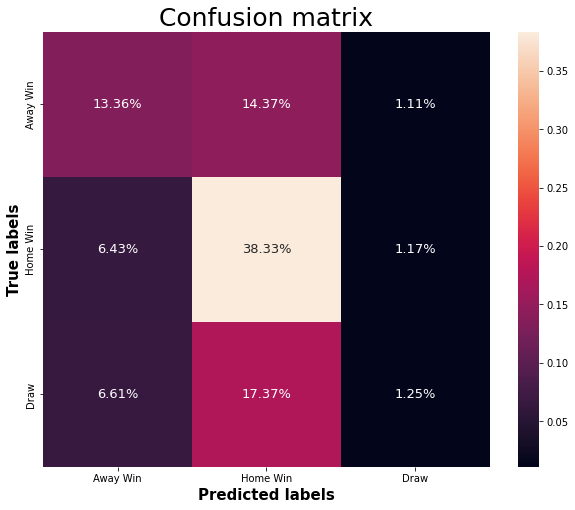

In [52]:
target_names = ['Away Win', 'Home Win', 'Draw']
cm = metrics.confusion_matrix(y_test, y_pred, labels = [1,2,3], normalize='all')
ax = plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm, annot=True, cbar=True, 
                 xticklabels=target_names, 
                 yticklabels=target_names,
                 annot_kws={'fontsize':13},
                 fmt=".2%")
ax.set_title('Confusion matrix', size=25)
ax.set_xlabel('Predicted labels', fontweight='bold', size=15)
ax.set_ylabel('True labels', fontweight='bold', size=15)
plt.show()

The model is really struggling to correctly predict matches that end in "Draw".

In [53]:
print(metrics.classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

    Away Win       0.51      0.46      0.48      1405
    Home Win       0.55      0.83      0.66      2237
        Draw       0.35      0.05      0.09      1229

    accuracy                           0.53      4871
   macro avg       0.47      0.45      0.41      4871
weighted avg       0.49      0.53      0.47      4871



Precision = (TP / TP + FP) - Out of all the examples that predicted as positive, how many are really positive?<br>
Recall = (TP / (TP + FN)) - Out of all the positive examples, how many are predicted as positive?<br>

### Predicting the score

Matches most often result in:

In [54]:
ls = df['score'].value_counts()[:20].index
df['score'] = [x if x in ls else 'other' for x in df['score']]
t = df['score'].value_counts().to_frame()
t['score_perc'] = round(t['score']/sum(t['score']),2)
t.head()

,score,score_perc
1:1,2236,0.11
1:0,1952,0.10
2:1,1654,0.08
2:0,1586,0.08
0:0,1457,0.07


Preparing and dividing the data:

In [55]:
X = df[df.columns[~df.columns.isin(['outcome', 'score'])]]
X.fillna(X.mean(), inplace=True)
cols = X.columns
sc = StandardScaler()
X = sc.fit_transform(X)
y = df[['score']]

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    stratify=y, 
                                                    test_size=0.25)

The most important features:

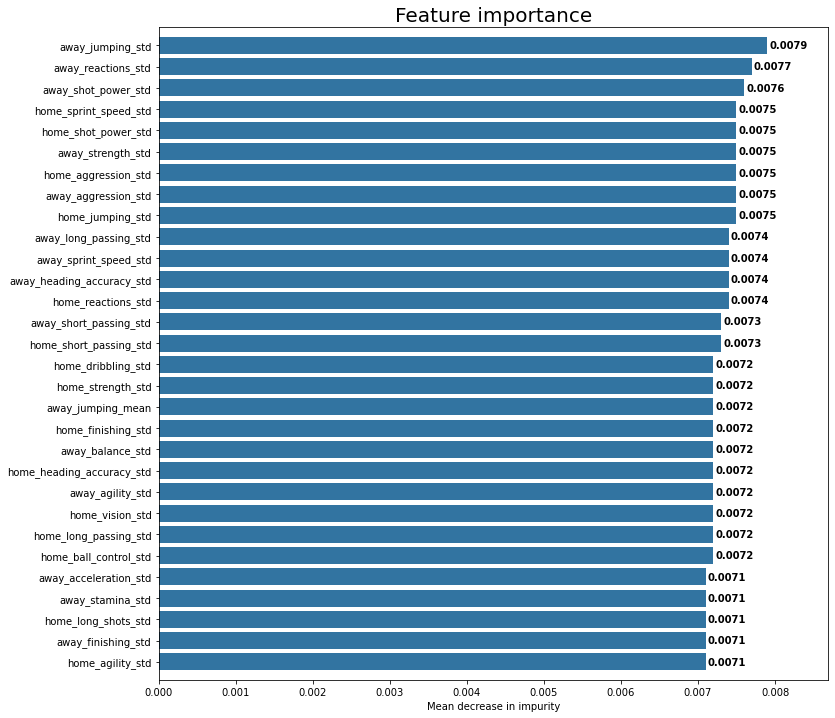

In [56]:
model = RandomForestClassifier(n_estimators=100, random_state=0)
model.fit(X_train, y_train)
importances = model.feature_importances_
importances = (pd.DataFrame(importances, cols, columns = ['importance']))\
  .round(4).sort_values(by='importance', ascending=False).reset_index()

fig = plt.figure(figsize=(12, 12))
ax = sns.barplot(x='importance', 
                 y='index', 
                 data=importances[:30], 
                 color=sns.color_palette()[0])
plt.title(label = 'Feature importance', size=20)
plt.xlabel('Mean decrease in impurity')
plt.ylabel('')
for i in ax.containers:
    ax.bar_label(i, padding=2, fontweight='bold')
ax.margins(x=0.1, y=0.015)

Creating the model:

In [57]:
model = LogisticRegression(solver='newton-cg', 
                           random_state=0, 
                           multi_class='multinomial').fit(X_train, y_train)

print("Intercept:\n",model.intercept_)
#print("Coefficients:\n",model.coef_)

y_pred = model.predict(X_test)
print("Few predictions:\n", y_pred[:10])

Intercept:
 [ 0.94519986  0.81966137  0.16731788 -1.08118946  1.28520138  1.45250543
  0.76563782 -0.34358576 -1.9072035   0.98325986  1.13313042  0.62669577
 -0.61055169 -0.02656143  0.3934724  -0.23834146 -1.32974702 -1.01323661
 -1.03642504 -1.62726346  0.64202323]
Few predictions:
 ['1:1' '2:1' 'other' '1:1' '0:0' '1:1' '2:1' '1:1' '1:2' '1:2']


In [58]:
print(f"Train set accuracy: {np.round(model.score(X_train, y_train),2)}") 
print(f"Test set accuracy:  {np.round(model.score(X_test, y_test),2)}") 

cross_val_acc = cross_val_score(estimator = model, X = X_train, y = y_train, cv = 10)
print(f"Cross validation accuracy: {round(cross_val_acc.mean(),2)}")

Train set accuracy: 0.16
Test set accuracy:  0.11
Cross validation accuracy: 0.11


Baseline for the model is 0.11 (baseline always guesssing the most often result 1:1). <br>
The model is equal the baseline - has to be improved.

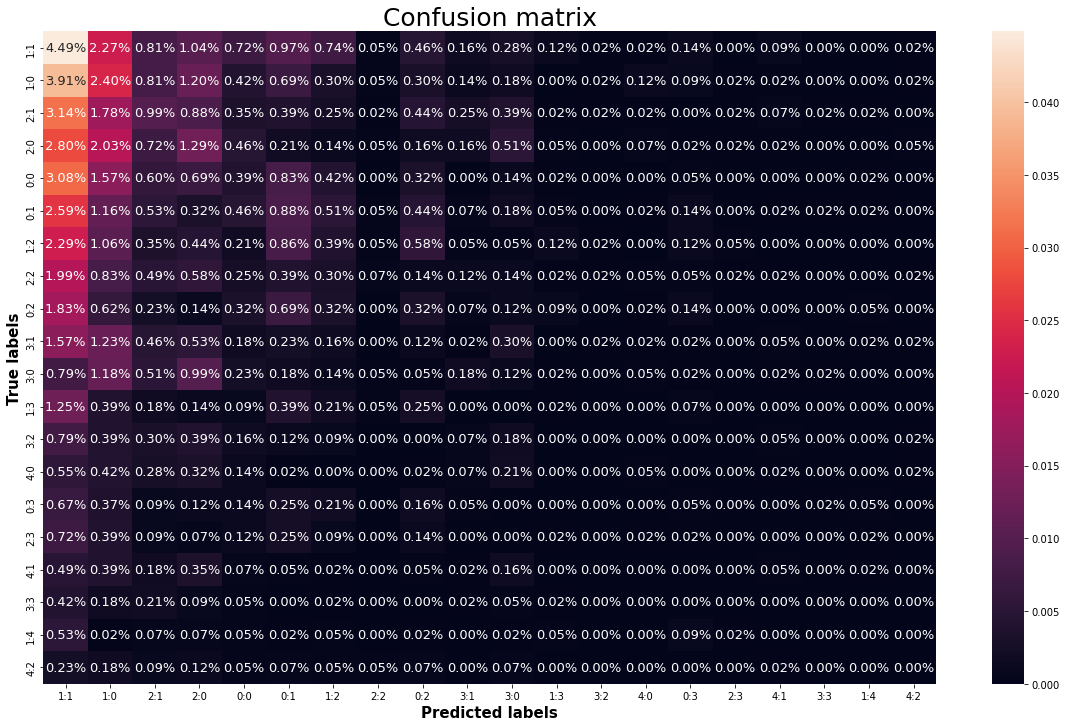

In [59]:
cm = metrics.confusion_matrix(y_test, y_pred, labels = ls, normalize='all')
ax = plt.figure(figsize=(20, 12))
ax = sns.heatmap(cm, annot=True, cbar=True, 
                 xticklabels=ls, 
                 yticklabels=ls,
                 annot_kws={'fontsize':13},
                 fmt=".2%")
ax.set_title('Confusion matrix', size=25)
ax.set_xlabel('Predicted labels', fontweight='bold', size=15)
ax.set_ylabel('True labels', fontweight='bold', size=15)
plt.show()

Model tends to predict score 1:1 more than other game scores.

## Data Studio chart
<a href='https://datastudio.google.com/u/0/reporting/92284d6e-4420-44d1-9cc5-9ab57c692853/page/QZcCD'>Link to the dashboard</a>

## Results
* Home team has a significant advantage.
* Betting odds data (especially from Bet365, Interwetten, Blue Square, Bet&Win) is very helpful in predicting the winner team.
* Implemented winner prediction (Test accuracy 54%)
* Implemented score prediction (Test accuracy 11% - has to be improved)

## What could be improved:
* Trying other ML models
* More hyper parameters' tunning
* Feature engineering, combining similar features